In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# Mengupload File

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving contenthealthcare-dataset-stroke-data.csv to contenthealthcare-dataset-stroke-data.csv


# Mengecek Dataset

In [ ]:
df = pd.read_csv('/content/healthcare-dataset-stroke-data.csv')
print(df.head())

# Melihat 5 baris pertama dataset
print("5 Baris Pertama Dataset:")
print(df.head())

# Informasi dataset
print("\nInformasi Dataset:")
print(df.info())

# Statistik deskriptif dataset (kolom numerik)
print("\nStatistik Deskriptif Dataset:")
print(df.describe())

# Melihat jumlah data null / missing values
print("\nJumlah Missing Values per Kolom:")
print(df.isnull().sum())

# Melihat distribusi target variable (stroke)
print("\nDistribusi Target Variable (stroke):")
print(df['stroke'].value_counts())


FileNotFoundError: [Errno 2] No such file or directory: '/content/healthcare-dataset-stroke-data.csv'

# Pembersihan Dataset

In [ ]:
# Cek jumlah missing value sebelum imputasi
print("Missing values sebelum imputasi:")
print(df['bmi'].isnull().sum())

# Imputasi nilai kosong di kolom 'bmi' dengan median
median_bmi = df['bmi'].median()
df['bmi'].fillna(median_bmi, inplace=True)

# Cek lagi missing value setelah imputasi
print("\nMissing values setelah imputasi:")
print(df['bmi'].isnull().sum())

Missing values sebelum imputasi:
201

Missing values setelah imputasi:
0


<ipython-input-5-d36c81ba02ba>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['bmi'].fillna(median_bmi, inplace=True)


# Normalisasi dengan Min-Max Normalization (Feature Scaling)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df[['age', 'avg_glucose_level', 'bmi']] = scaler.fit_transform(df[['age', 'avg_glucose_level', 'bmi']])

# pra-pemrosesan data

In [ ]:
# Copy data
df_encoded = df.copy()

# Encoding kategori
categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])

# Fitur dan target
X = df_encoded.drop(columns=['stroke', 'id'])
y = df_encoded['stroke']

# Scaling fitur numerik
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Clustering dengan algoritma K-Means

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=42)
clusters_kmeans = kmeans.fit_predict(X_scaled)

print("Distribusi cluster KMeans:", Counter(clusters_kmeans))

Distribusi cluster KMeans: Counter({np.int32(0): 2403, np.int32(1): 951, np.int32(4): 715, np.int32(3): 576, np.int32(2): 465})


# Clustering dengan algoritma DBSCAN

In [ ]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters_dbscan = dbscan.fit_predict(X_scaled)

print("Distribusi cluster DBSCAN:", Counter(clusters_dbscan))

Distribusi cluster DBSCAN: Counter({np.int64(-1): 2660, np.int64(4): 169, np.int64(9): 165, np.int64(26): 163, np.int64(21): 147, np.int64(27): 141, np.int64(24): 132, np.int64(25): 95, np.int64(12): 92, np.int64(6): 76, np.int64(33): 76, np.int64(31): 62, np.int64(0): 59, np.int64(16): 59, np.int64(1): 58, np.int64(5): 56, np.int64(2): 55, np.int64(36): 52, np.int64(7): 51, np.int64(3): 45, np.int64(15): 45, np.int64(28): 45, np.int64(13): 44, np.int64(30): 36, np.int64(10): 31, np.int64(17): 29, np.int64(32): 28, np.int64(29): 27, np.int64(11): 24, np.int64(23): 24, np.int64(40): 21, np.int64(44): 21, np.int64(38): 17, np.int64(35): 17, np.int64(45): 14, np.int64(37): 13, np.int64(39): 12, np.int64(47): 11, np.int64(19): 11, np.int64(8): 9, np.int64(22): 9, np.int64(50): 9, np.int64(46): 9, np.int64(20): 8, np.int64(34): 8, np.int64(62): 8, np.int64(55): 8, np.int64(52): 7, np.int64(59): 7, np.int64(61): 7, np.int64(14): 6, np.int64(60): 6, np.int64(57): 6, np.int64(54): 5, np.int64(

# Membandingkan Model KMeans dan model SMOTETomek

In [ ]:
smt = SMOTETomek(random_state=42)

# Terapkan SMOTETomek pada data dengan cluster KMeans sebagai fitur tambahan
X_km_smt = np.hstack((X_scaled, clusters_kmeans.reshape(-1,1)))
X_res_km_smt, y_res_km_smt = smt.fit_resample(X_km_smt, y)

print("Distribusi setelah KMeans + SMOTETomek:", Counter(y_res_km_smt))

Distribusi setelah KMeans + SMOTETomek: Counter({1: 4833, 0: 4833})


# Membandingkan Model *DBSCAN* dan model SMOTETomek

In [ ]:
# DBSCAN cluster bisa bernilai -1 untuk noise, ganti dulu -1 jadi cluster tersendiri (misal 99)
clusters_dbscan_fixed = np.where(clusters_dbscan == -1, 99, clusters_dbscan)

X_db_smt = np.hstack((X_scaled, clusters_dbscan_fixed.reshape(-1,1)))
X_res_db_smt, y_res_db_smt = smt.fit_resample(X_db_smt, y)

print("Distribusi setelah DBSCAN + SMOTETomek:", Counter(y_res_db_smt))

Distribusi setelah DBSCAN + SMOTETomek: Counter({1: 4829, 0: 4829})


# Membandingkan Model KMeans dan model Undersampling

In [ ]:
rus = RandomUnderSampler(random_state=42)

X_km_rus = np.hstack((X_scaled, clusters_kmeans.reshape(-1,1)))
X_res_km_rus, y_res_km_rus = rus.fit_resample(X_km_rus, y)

print("Distribusi setelah KMeans + Undersampling:", Counter(y_res_km_rus))

Distribusi setelah KMeans + Undersampling: Counter({0: 249, 1: 249})


# Membandingkan Model DBSCAN dan model Undersampling

In [ ]:
X_db_rus = np.hstack((X_scaled, clusters_dbscan_fixed.reshape(-1,1)))
X_res_db_rus, y_res_db_rus = rus.fit_resample(X_db_rus, y)

print("Distribusi setelah DBSCAN + Undersampling:", Counter(y_res_db_rus))

Distribusi setelah DBSCAN + Undersampling: Counter({0: 249, 1: 249})


# Imbalanced dataset

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# Resampling

In [ ]:
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Split data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Prediksi

In [ ]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Evaluasi

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nROC AUC Score:")
print(roc_auc_score(y_test, y_proba))


Confusion Matrix:
[[859 116]
 [ 28 942]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.88      0.92       975
           1       0.89      0.97      0.93       970

    accuracy                           0.93      1945
   macro avg       0.93      0.93      0.93      1945
weighted avg       0.93      0.93      0.93      1945


ROC AUC Score:
0.9812371134020619


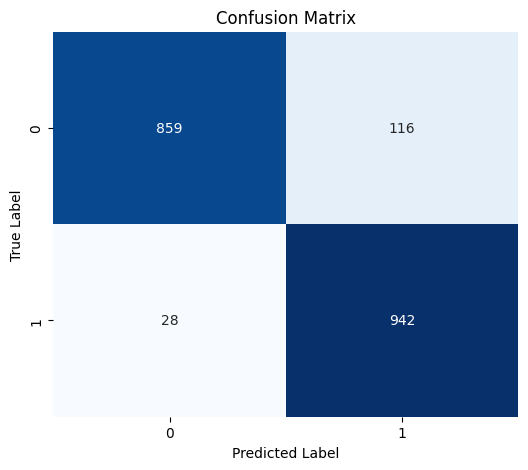

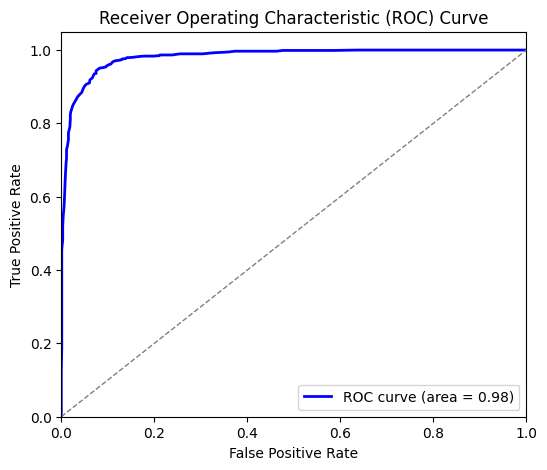

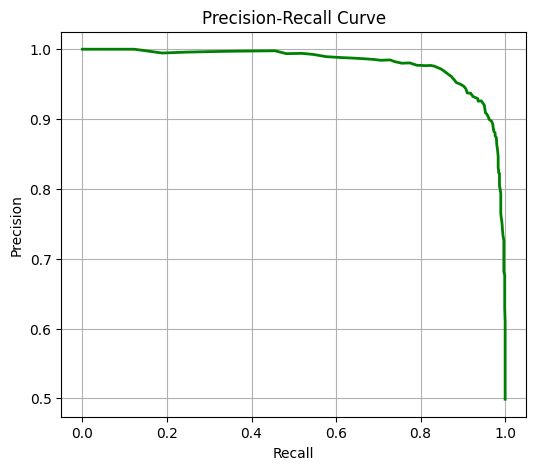

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, color='green', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()


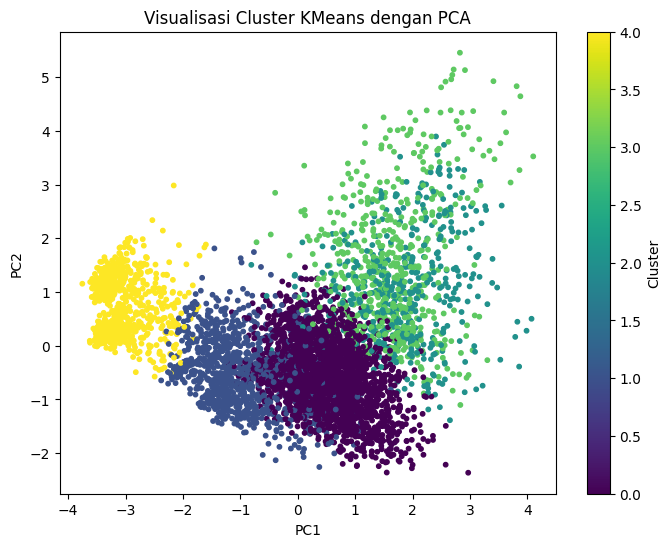

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters_kmeans, cmap='viridis', s=10)
plt.title('Visualisasi Cluster KMeans dengan PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Cluster')
plt.show()


In [ ]:
from collections import Counter
print("Distribusi Cluster KMeans:")
print(Counter(clusters_kmeans))

Distribusi Cluster KMeans:
Counter({np.int32(0): 2403, np.int32(1): 951, np.int32(4): 715, np.int32(3): 576, np.int32(2): 465})


In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# Misal data sudah diskalakan di X_scaled

# Jalankan KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
clusters_kmeans = kmeans.fit_predict(X_scaled)

# Hitung Silhouette Score
score_kmeans = silhouette_score(X_scaled, clusters_kmeans)
print(f'Silhouette Score untuk KMeans: {score_kmeans:.4f}')


Silhouette Score untuk KMeans: 0.2036


In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Jalankan DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters_dbscan = dbscan.fit_predict(X_scaled)

# Silhouette Score tidak dihitung untuk noise (-1), jadi filter data noise dulu
mask = clusters_dbscan != -1
score_dbscan = silhouette_score(X_scaled[mask], clusters_dbscan[mask])
print(f'Silhouette Score untuk DBSCAN: {score_dbscan:.4f}')


Silhouette Score untuk DBSCAN: 0.3140


Silhouette Score KMeans: 0.2036
Distribusi cluster KMeans: Counter({np.int32(0): 2403, np.int32(1): 951, np.int32(4): 715, np.int32(3): 576, np.int32(2): 465})
Silhouette Score DBSCAN (tanpa noise): 0.3140
Distribusi cluster DBSCAN: Counter({np.int64(-1): 2660, np.int64(4): 169, np.int64(9): 165, np.int64(26): 163, np.int64(21): 147, np.int64(27): 141, np.int64(24): 132, np.int64(25): 95, np.int64(12): 92, np.int64(6): 76, np.int64(33): 76, np.int64(31): 62, np.int64(0): 59, np.int64(16): 59, np.int64(1): 58, np.int64(5): 56, np.int64(2): 55, np.int64(36): 52, np.int64(7): 51, np.int64(3): 45, np.int64(15): 45, np.int64(28): 45, np.int64(13): 44, np.int64(30): 36, np.int64(10): 31, np.int64(17): 29, np.int64(32): 28, np.int64(29): 27, np.int64(11): 24, np.int64(23): 24, np.int64(40): 21, np.int64(44): 21, np.int64(38): 17, np.int64(35): 17, np.int64(45): 14, np.int64(37): 13, np.int64(39): 12, np.int64(47): 11, np.int64(19): 11, np.int64(8): 9, np.int64(22): 9, np.int64(50): 9, np.int6

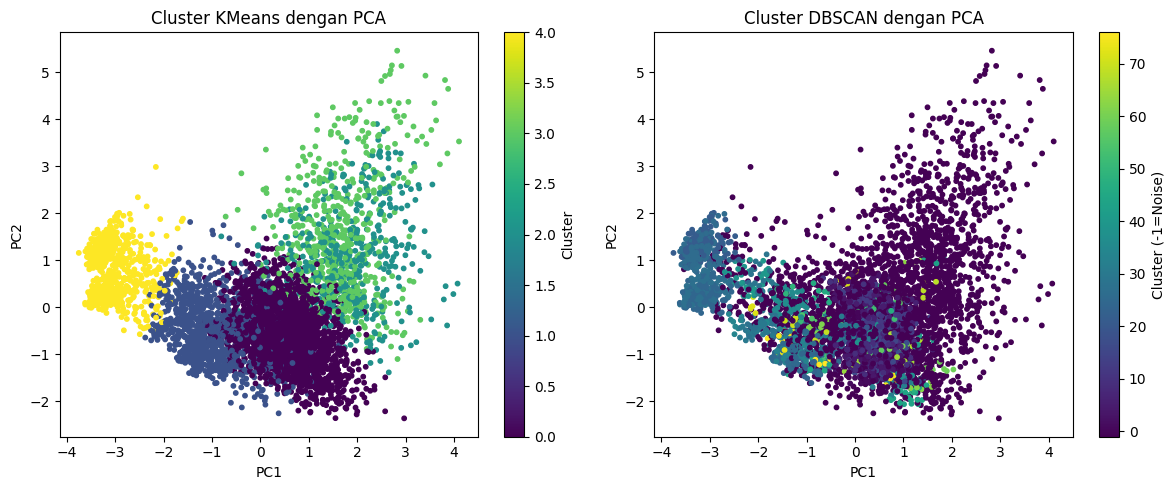

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from collections import Counter

# Misal X_scaled adalah data fitur yang sudah diskalakan

# KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)
clusters_kmeans = kmeans.fit_predict(X_scaled)
score_kmeans = silhouette_score(X_scaled, clusters_kmeans)
print(f'Silhouette Score KMeans: {score_kmeans:.4f}')
print('Distribusi cluster KMeans:', Counter(clusters_kmeans))

# DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters_dbscan = dbscan.fit_predict(X_scaled)

# DBSCAN memberi label -1 untuk noise, harus diabaikan saat hitung Silhouette Score
mask = clusters_dbscan != -1
if len(set(clusters_dbscan[mask])) > 1:
    score_dbscan = silhouette_score(X_scaled[mask], clusters_dbscan[mask])
    print(f'Silhouette Score DBSCAN (tanpa noise): {score_dbscan:.4f}')
else:
    print('DBSCAN cluster kurang dari 2 (tidak bisa hitung Silhouette Score)')

print('Distribusi cluster DBSCAN:', Counter(clusters_dbscan))

# Visualisasi PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12, 5))

# Plot KMeans
plt.subplot(1, 2, 1)
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters_kmeans, cmap='viridis', s=10)
plt.colorbar(scatter, label='Cluster')
plt.title('Cluster KMeans dengan PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')

# Plot DBSCAN
plt.subplot(1, 2, 2)
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters_dbscan, cmap='viridis', s=10)
plt.colorbar(scatter, label='Cluster (-1=Noise)')
plt.title('Cluster DBSCAN dengan PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.tight_layout()
plt.show()

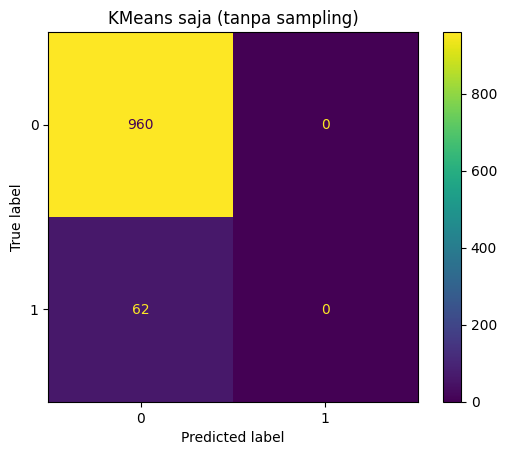

Confusion Matrix untuk KMeans saja (tanpa sampling):
[[960   0]
 [ 62   0]]



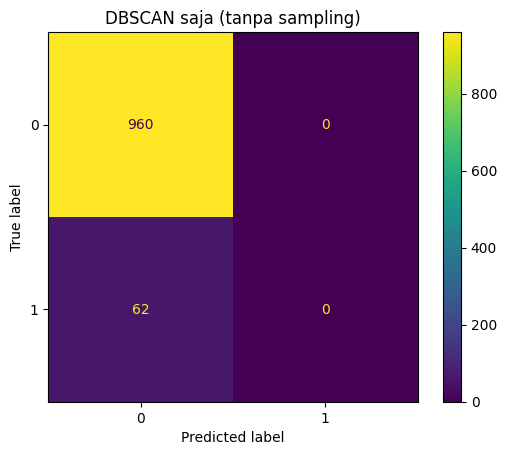

Confusion Matrix untuk DBSCAN saja (tanpa sampling):
[[960   0]
 [ 62   0]]



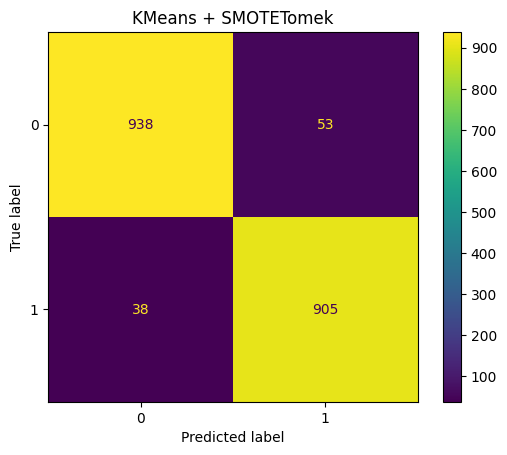

Confusion Matrix untuk KMeans + SMOTETomek:
[[938  53]
 [ 38 905]]



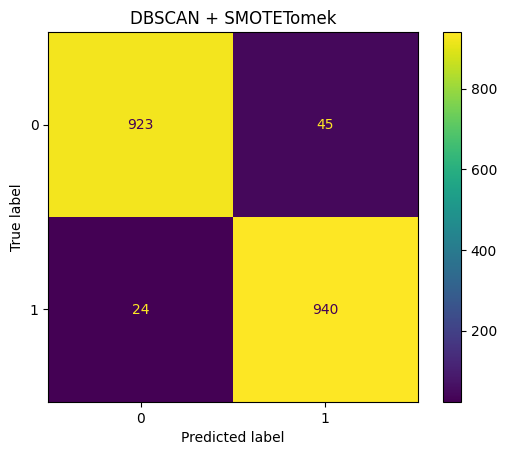

Confusion Matrix untuk DBSCAN + SMOTETomek:
[[923  45]
 [ 24 940]]



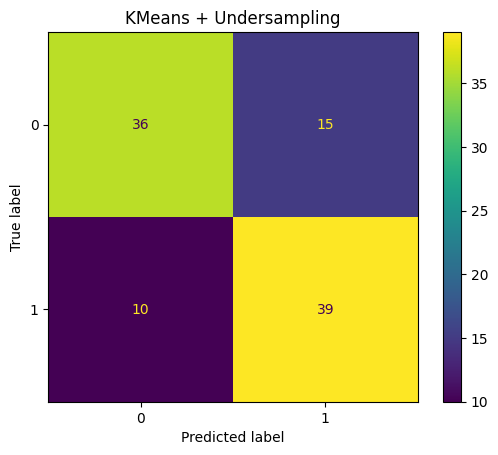

Confusion Matrix untuk KMeans + Undersampling:
[[36 15]
 [10 39]]



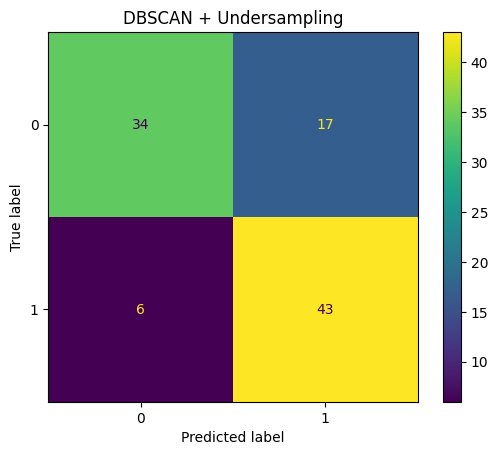

Confusion Matrix untuk DBSCAN + Undersampling:
[[34 17]
 [ 6 43]]



In [ ]:
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Clustering
kmeans = KMeans(n_clusters=5, random_state=42)
clusters_kmeans = kmeans.fit_predict(X_scaled)

dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters_dbscan = dbscan.fit_predict(X_scaled)
clusters_dbscan_fixed = np.where(clusters_dbscan == -1, 99, clusters_dbscan)

# Tambah cluster sebagai fitur tambahan
X_km = np.hstack((X_scaled, clusters_kmeans.reshape(-1,1)))
X_db = np.hstack((X_scaled, clusters_dbscan_fixed.reshape(-1,1)))

# Data split untuk evaluation
def train_evaluate(X, y, title):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(title)
    plt.show()
    print(f"Confusion Matrix untuk {title}:\n{cm}\n")

# 1. KMeans saja
train_evaluate(X_scaled, y, "KMeans saja (tanpa sampling)")

# 2. DBSCAN saja
train_evaluate(X_scaled, y, "DBSCAN saja (tanpa sampling)")

# 3. KMeans + SMOTETomek
smt = SMOTETomek(random_state=42)
X_res_km_smt, y_res_km_smt = smt.fit_resample(X_km, y)
train_evaluate(X_res_km_smt, y_res_km_smt, "KMeans + SMOTETomek")

# 4. DBSCAN + SMOTETomek
X_res_db_smt, y_res_db_smt = smt.fit_resample(X_db, y)
train_evaluate(X_res_db_smt, y_res_db_smt, "DBSCAN + SMOTETomek")

# 5. KMeans + Undersampling
rus = RandomUnderSampler(random_state=42)
X_res_km_rus, y_res_km_rus = rus.fit_resample(X_km, y)
train_evaluate(X_res_km_rus, y_res_km_rus, "KMeans + Undersampling")

# 6. DBSCAN + Undersampling
X_res_db_rus, y_res_db_rus = rus.fit_resample(X_db, y)
train_evaluate(X_res_db_rus, y_res_db_rus, "DBSCAN + Undersampling")

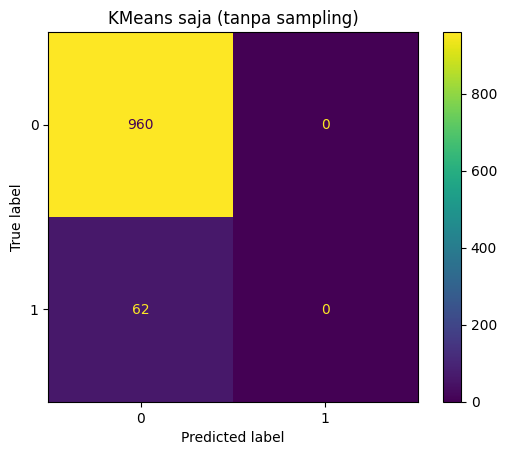

Classification Report untuk KMeans saja (tanpa sampling):
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       960
           1       0.00      0.00      0.00        62

    accuracy                           0.94      1022
   macro avg       0.47      0.50      0.48      1022
weighted avg       0.88      0.94      0.91      1022



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


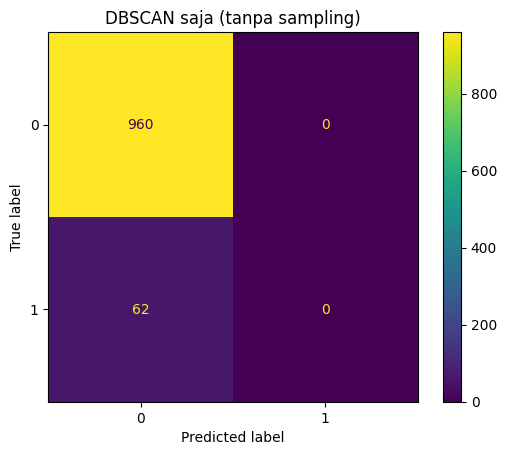

Classification Report untuk DBSCAN saja (tanpa sampling):
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       960
           1       0.00      0.00      0.00        62

    accuracy                           0.94      1022
   macro avg       0.47      0.50      0.48      1022
weighted avg       0.88      0.94      0.91      1022



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


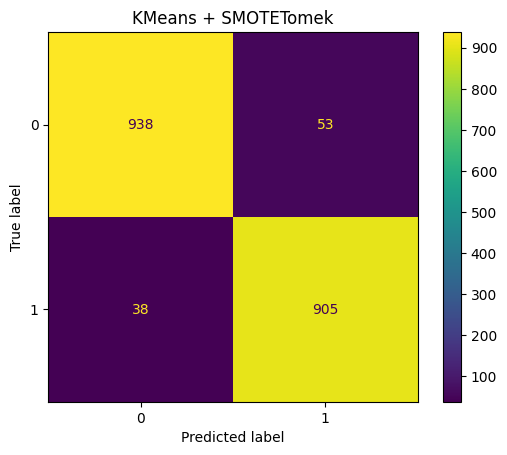

Classification Report untuk KMeans + SMOTETomek:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       991
           1       0.94      0.96      0.95       943

    accuracy                           0.95      1934
   macro avg       0.95      0.95      0.95      1934
weighted avg       0.95      0.95      0.95      1934



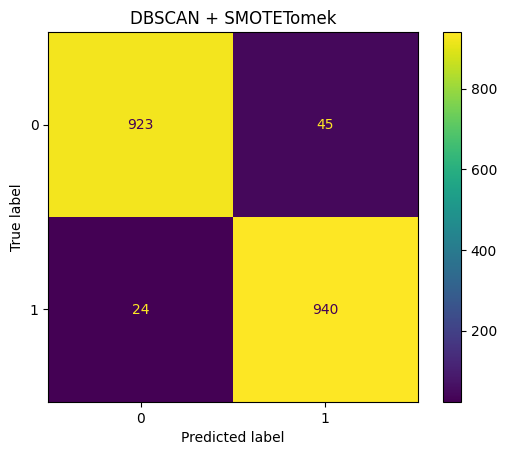

Classification Report untuk DBSCAN + SMOTETomek:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       968
           1       0.95      0.98      0.96       964

    accuracy                           0.96      1932
   macro avg       0.96      0.96      0.96      1932
weighted avg       0.96      0.96      0.96      1932



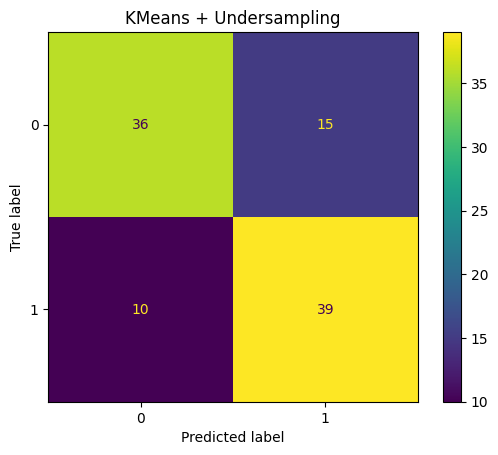

Classification Report untuk KMeans + Undersampling:
              precision    recall  f1-score   support

           0       0.78      0.71      0.74        51
           1       0.72      0.80      0.76        49

    accuracy                           0.75       100
   macro avg       0.75      0.75      0.75       100
weighted avg       0.75      0.75      0.75       100



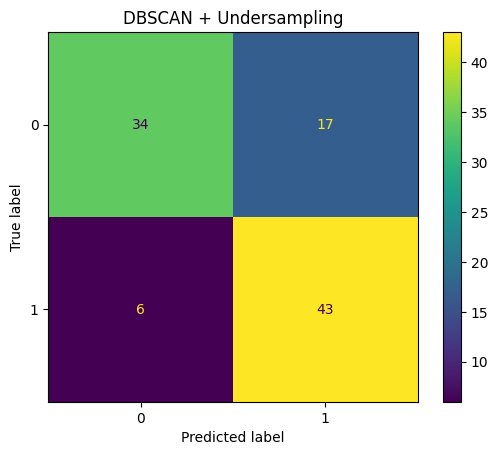

Classification Report untuk DBSCAN + Undersampling:
              precision    recall  f1-score   support

           0       0.85      0.67      0.75        51
           1       0.72      0.88      0.79        49

    accuracy                           0.77       100
   macro avg       0.78      0.77      0.77       100
weighted avg       0.78      0.77      0.77       100



In [ ]:
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# Clustering
kmeans = KMeans(n_clusters=5, random_state=42)
clusters_kmeans = kmeans.fit_predict(X_scaled)

dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters_dbscan = dbscan.fit_predict(X_scaled)
clusters_dbscan_fixed = np.where(clusters_dbscan == -1, 99, clusters_dbscan)

# Tambah cluster sebagai fitur tambahan
X_km = np.hstack((X_scaled, clusters_kmeans.reshape(-1,1)))
X_db = np.hstack((X_scaled, clusters_dbscan_fixed.reshape(-1,1)))

# Data split untuk evaluation
def train_evaluate(X, y, title):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(title)
    plt.show()

    print(f"Classification Report untuk {title}:")
    print(classification_report(y_test, y_pred))

# 1. KMeans saja
train_evaluate(X_scaled, y, "KMeans saja (tanpa sampling)")

# 2. DBSCAN saja
train_evaluate(X_scaled, y, "DBSCAN saja (tanpa sampling)")

# 3. KMeans + SMOTETomek
smt = SMOTETomek(random_state=42)
X_res_km_smt, y_res_km_smt = smt.fit_resample(X_km, y)
train_evaluate(X_res_km_smt, y_res_km_smt, "KMeans + SMOTETomek")

# 4. DBSCAN + SMOTETomek
X_res_db_smt, y_res_db_smt = smt.fit_resample(X_db, y)
train_evaluate(X_res_db_smt, y_res_db_smt, "DBSCAN + SMOTETomek")

# 5. KMeans + Undersampling
rus = RandomUnderSampler(random_state=42)
X_res_km_rus, y_res_km_rus = rus.fit_resample(X_km, y)
train_evaluate(X_res_km_rus, y_res_km_rus, "KMeans + Undersampling")

# 6. DBSCAN + Undersampling
X_res_db_rus, y_res_db_rus = rus.fit_resample(X_db, y)
train_evaluate(X_res_db_rus, y_res_db_rus, "DBSCAN + Undersampling")
